<a href="https://colab.research.google.com/github/18520381/434_Project_10/blob/main/VGG16%20Project/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Get data

In [25]:
from google.colab import drive
from torchvision import models
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ColabNotebooks/data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ColabNotebooks/data


In [50]:
import warnings
warnings.filterwarnings('ignore')

import cv2       
import os

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, classification_report
from sklearn.preprocessing import LabelEncoder

from keras.layers import Dense
from keras.layers import Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam, RMSprop, SGD
from keras.utils import to_categorical    
from keras.models import Sequential
from keras.applications import VGG16
from keras.callbacks import ReduceLROnPlateau

import random as rn
from tqdm import tqdm

Import data

In [51]:
CLASS_NAME = ["apple", "orange"]
DATA_PATH = "../data/fruit/"
img_size = 112

images = []
labels = []
pbar = tqdm(total=2000)
for class_name in CLASS_NAME:
    for _, _, files in os.walk(DATA_PATH+class_name, topdown=False):
        for name in files:
            image = cv2.imread(DATA_PATH+""+class_name+"/"+name)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (img_size,img_size))

            images.append(np.array(image))
            labels.append(str(class_name))

            pbar.update(1)
pbar.close()


100%|██████████| 2000/2000 [00:18<00:00, 106.32it/s]


In [52]:
data = np.array(images)
labels = np.array(labels)

In [53]:
le = LabelEncoder()
y = le.fit_transform(labels)
y = to_categorical(y, 2)
X = data/255
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 5)

np.random.seed(50)
rn.seed(50)

Preparing Base model

In [54]:
Base_model = VGG16(include_top= False, weights='imagenet',input_shape=(img_size,img_size,3), pooling='max')
Base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 112, 112, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 112, 112, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 112, 112, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 56, 56, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 56, 56, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 56, 56, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 28, 28, 128)       0     

Fully connected Layers

In [55]:
model = Sequential()

model.add(Base_model)
model.add(Dense(256,activation='relu'))
model.add(Dense(2,activation="softmax"))
Base_model.trainable = False

Annealer

In [56]:
# Learning rate
red_lr=ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=0.0001, patience=2, verbose=1)

Data augmentation to prevent Overfitting

In [57]:
datagen = ImageDataGenerator(featurewise_center= False,
                              samplewise_center= False,
                              featurewise_std_normalization= False,
                              samplewise_std_normalization=False,
                              rotation_range= 0,        
                              zca_whitening=False,
                              zoom_range=0.1,           
                              width_shift_range=0.1,   
                              height_shift_range=0.1,    
                              horizontal_flip=True,     
                              vertical_flip=False)       
                             
datagen.fit(X_train)

In [58]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 514       
Total params: 14,846,530
Trainable params: 131,842
Non-trainable params: 14,714,688
_________________________________________________________________


Compile and train the model

In [78]:
model.compile(optimizer=Adam(lr = 5e-5), loss= 'categorical_crossentropy', metrics=['accuracy'])

In [79]:
batch_size=64
History = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = 3, validation_data = (X_test,y_test),                            
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size)

Epoch 1/3
25/25 [==============================] - 252s 10s/step - loss: 0.4067 - accuracy: 0.8145 - val_loss: 0.5544 - val_accuracy: 0.7150
Epoch 2/3
25/25 [==============================] - 250s 10s/step - loss: 0.3976 - accuracy: 0.8353 - val_loss: 0.5370 - val_accuracy: 0.7300
Epoch 3/3
25/25 [==============================] - 251s 10s/step - loss: 0.4102 - accuracy: 0.8113 - val_loss: 0.5403 - val_accuracy: 0.7350


Text(0, 0.5, 'Accuracy')

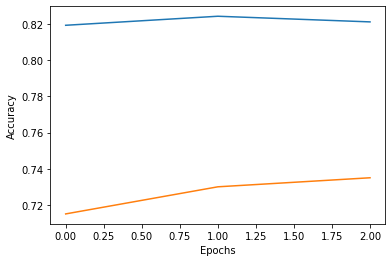

In [80]:
plt.plot(History.epoch, History.history['accuracy'])
plt.plot(History.epoch, History.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

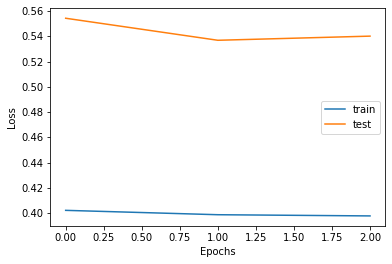

In [81]:
plt.plot(History.epoch, History.history['loss'])
plt.plot(History.epoch, History.history['val_loss'])
plt.legend(['train', 'test'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

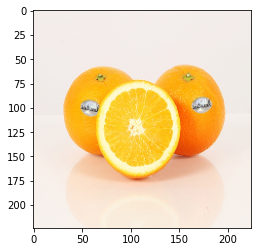

orange


In [82]:
import numpy as np
from keras.preprocessing import image

path = '/content/drive/MyDrive/ColabNotebooks/data/test/orange/orange_2.jpg'
test_img = cv2.imread(path)
test_img = cv2.resize(test_img,(224,224))
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
plt.imshow(test_img)
plt.show()

img = image.load_img(path, target_size = (img_size, img_size))
img = image.img_to_array(img)
img = np.expand_dims(img, axis = 0)
result = model.predict(img)

if result[0][0] == 1:
  prediction = 'apple'
else:
  prediction = 'orange'
print(prediction)

Save model


In [85]:
model.save("model3.h5")

In [84]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

weights_1 = model.layers[2].get_weights()[0]

print("block1_conv2d1:\n", weights_1)


block1_conv2d1:
 [[ 0.05211165  0.1367744 ]
 [-0.08682537  0.15331246]
 [-0.10550633  0.09400705]
 [ 0.03688201  0.13837694]
 [-0.02558929 -0.00198105]
 [-0.03013561  0.03870212]
 [ 0.07863408 -0.10761449]
 [ 0.08347844 -0.10531823]
 [-0.10309941  0.10876691]
 [ 0.09132297 -0.053595  ]
 [ 0.13529745 -0.11236818]
 [-0.06626373 -0.0151953 ]
 [-0.13361679  0.08233898]
 [ 0.12664127 -0.13654648]
 [ 0.07306752  0.03427773]
 [-0.17234908  0.0550578 ]
 [-0.06690675  0.01517238]
 [ 0.05103511  0.13811526]
 [-0.16231374 -0.04702413]
 [-0.01244967 -0.01250037]
 [ 0.12217374 -0.02333051]
 [-0.1156805  -0.08346337]
 [ 0.01966249  0.04581781]
 [ 0.03986434  0.10040709]
 [-0.0604541   0.14488909]
 [ 0.03382582 -0.04040866]
 [ 0.04476376  0.15995936]
 [-0.02724193  0.02406845]
 [ 0.08262637  0.11199734]
 [-0.05204458 -0.10140213]
 [ 0.1415885   0.04950609]
 [-0.11699205  0.1381458 ]
 [-0.16958672 -0.05682615]
 [-0.13654107  0.07133337]
 [ 0.09854519 -0.08017813]
 [ 0.14617716  0.02766525]
 [ 0.070058

In [77]:
import h5py
import numpy as np

weights_path = '/content/drive/MyDrive/ColabNotebooks/data/model2.h5' 
f = h5py.File(weights_path)

list_blocks = ['block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 
'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3']
def write_weights(file_b,file_k, file_in, block):
    for listweights in (file_in["model_weights"]["vgg16"][block]["bias:0"]):
        file_b.writelines('%s\n' % listweights)
    for listweights in (file_in["model_weights"]["vgg16"][block]["kernel:0"]):
        for i in range(3):
            if(i==0):
                file_k.write("Channel B\n")
                np.savetxt(file_k, listweights[i])
            if(i==1):
                file_k.write("Channel G\n")
                np.savetxt(file_k, listweights[i])
            if(i==2):
                file_k.write("Channel R\n")
                np.savetxt(file_k, listweights[i])
    return file_b, file_k

f1_b = open('block1_conv1_bias.txt', 'w')
f1_k = open('block1_conv1_kernel.txt', 'w')
write_weights(f1_b, f1_k, f,list_blocks[0])
f1_b.close()
f1_k.close()

f2_b = open('block1_conv2_bias.txt', 'w')
f2_k = open('block1_conv2_kernel.txt', 'w')
write_weights(f2_b, f2_k, f, list_blocks[1])
f2_b.close()
f2_k.close()

f3_b = open('block2_conv1_bias.txt', 'w')
f3_k = open('block2_conv1_kernel.txt', 'w')
write_weights(f3_b, f3_k, f, list_blocks[2])
f3_b.close()
f3_k.close()

f4_b = open('block2_conv2_bias.txt', 'w')
f4_k = open('block2_conv2_kernel.txt', 'w')
write_weights(f4_b, f4_k, f, list_blocks[3]) 
f4_b.close()
f4_k.close()

f5_b = open('block3_conv1_bias.txt', 'w')
f5_k = open('block3_conv1_kernel.txt', 'w')
write_weights(f5_b, f5_k, f, list_blocks[4])
f5_b.close()
f5_k.close()

f6_b = open('block3_conv2_bias.txt', 'w')
f6_k = open('block3_conv2_kernel.txt', 'w')
write_weights(f6_b, f6_k, f, list_blocks[5])
f6_b.close()
f6_k.close()

f7_b = open('block3_conv3_bias.txt', 'w')
f7_k = open('block3_conv3_kernel.txt', 'w')
write_weights(f7_b, f7_k, f, list_blocks[6]) 
f7_b.close()
f7_k.close()

f8_b = open('block4_conv1_bias.txt', 'w')
f8_k = open('block4_conv1_kernel.txt', 'w')
write_weights(f8_b, f8_k, f, list_blocks[7])
f8_b.close()
f8_k.close()

f9_b = open('block4_conv2_bias.txt', 'w')
f9_k = open('block4_conv2_kernel.txt', 'w')
write_weights(f9_b, f9_k, f, list_blocks[8])   
f9_b.close()
f9_k.close()

f10_b = open('block4_conv3_bias.txt', 'w')
f10_k = open('block4_conv3_kernel.txt', 'w')
write_weights(f10_b, f10_k, f, list_blocks[9])   
f10_b.close()
f10_k.close()

f11_b = open('block5_conv1_bias.txt', 'w')
f11_k = open('block5_conv1_kernel.txt', 'w')
write_weights(f11_b, f11_k, f, list_blocks[10])  
f11_b.close()
f11_k.close()

f12_b = open('block5_conv2_bias.txt', 'w')
f12_k = open('block5_conv2_kernel.txt', 'w')
write_weights(f12_b, f12_k, f, list_blocks[11])   
f12_b.close()
f12_k.close()


f13_b = open('block5_conv3_bias.txt', 'w')
f13_k = open('block5_conv3_kernel.txt', 'w')
write_weights(f13_b, f13_k, f, list_blocks[12])   
f13_b.close()
f13_k.close()

In [74]:
import struct
def binary(num):
    return ''.join('{:0>8b}'.format(c) for c in struct.pack('!f', num))